In [82]:
import torch
import torch.nn as nn
import networkx as nx
import numpy as np
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt

In [110]:
import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root = 'data/TUDataset',name='PROTEINS',use_node_attr=True).shuffle()

print(torch_geometric.__version__)
print(f'Number of graphs {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

2.1.0
Number of graphs 1113
Number of features: 4
Number of classes: 2


edge_index means there are 134 edges. X is the feature matrix with 37 nodes and feature vector of size 0. Just a single value for the label, thus classification

In [36]:
dataset[2]

Data(edge_index=[2, 92], x=[25, 3], y=[1])

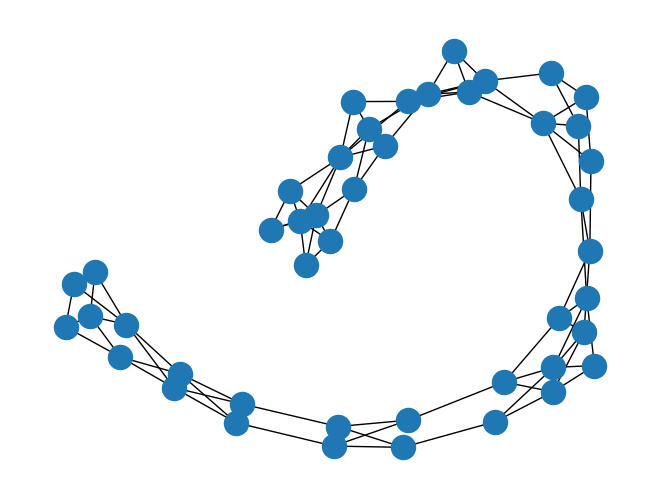

In [39]:
G = to_networkx(dataset[100],to_undirected=True)

nx.draw(G)
plt.show()

In [111]:
train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset  = dataset[int(len(dataset)*0.8):]

print(f'Training set   = {len(train_dataset)} graphs')
print(f'Test set       = {len(test_dataset)} graphs')

# Create mini-batches
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Training set   = 890 graphs
Test set       = 223 graphs


In [112]:
tmp = [x for x in train_loader]
print(len(train_loader))
print(train_dataset)
print(tmp)

14
PROTEINS(890)
[DataBatch(edge_index=[2, 8028], x=[2141, 4], y=[64], batch=[2141], ptr=[65]), DataBatch(edge_index=[2, 8470], x=[2309, 4], y=[64], batch=[2309], ptr=[65]), DataBatch(edge_index=[2, 10620], x=[2902, 4], y=[64], batch=[2902], ptr=[65]), DataBatch(edge_index=[2, 12604], x=[3333, 4], y=[64], batch=[3333], ptr=[65]), DataBatch(edge_index=[2, 8834], x=[2436, 4], y=[64], batch=[2436], ptr=[65]), DataBatch(edge_index=[2, 7776], x=[2106, 4], y=[64], batch=[2106], ptr=[65]), DataBatch(edge_index=[2, 10834], x=[2955, 4], y=[64], batch=[2955], ptr=[65]), DataBatch(edge_index=[2, 7486], x=[2092, 4], y=[64], batch=[2092], ptr=[65]), DataBatch(edge_index=[2, 8804], x=[2382, 4], y=[64], batch=[2382], ptr=[65]), DataBatch(edge_index=[2, 8878], x=[2221, 4], y=[64], batch=[2221], ptr=[65]), DataBatch(edge_index=[2, 9766], x=[2665, 4], y=[64], batch=[2665], ptr=[65]), DataBatch(edge_index=[2, 8484], x=[2245, 4], y=[64], batch=[2245], ptr=[65]), DataBatch(edge_index=[2, 8156], x=[2209, 4]

In [113]:
from torch_geometric.nn import GINConv, GCNConv
from torch.nn import Linear, BatchNorm1d, Sequential, ReLU
from torch_geometric.nn import global_add_pool, global_mean_pool
import torch.nn.functional as F
class GIN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim),
                       BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim, dim), BatchNorm1d(dim), ReLU(),
                       Linear(dim, dim), ReLU()))
        self.linear = Linear(dim*3, dataset.num_classes)

    def forward(self, x):
        h1 = self.conv1(x)
        h2 = self.conv2(h1)
        h3 = self.conv3(h2)

        h1 = global_add_pool(h1)
        h2 = global_add_pool(h2)
        h3 = global_add_pool(h3)

        h = torch.cat((h1, h2, h3), dim=1)

        h = self.linear(h)
        
        return h
gin = GIN(64)

In [115]:
class GNN(nn.Module):
    def __init__(self, dim, num_class):
        super().__init__()
        self.conv1 = GCNConv(dim,64)
        self.conv2 = GCNConv(64,64)
        self.conv3 = GCNConv(64,64)
        self.lin = nn.Linear(64,num_class)
    def forward(self, x, edge_index,batch):
        x = F.relu(self.conv1(x,edge_index))
        x = F.relu(self.conv2(x,edge_index))
        x = self.conv3(x,edge_index)
        x = global_mean_pool(x,batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x
model = GNN(dim=4,num_class=2)
        

In [116]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(),lr=0.01)
crit = nn.CrossEntropyLoss()
def train():
    model.train()

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x,data.edge_index,data.batch)
        loss = crit(out,data.y)
        loss.backward()
        optimizer.step()

In [117]:
def test(test_loader):
    model.eval()
    correct = 0
    for data in test_loader:
        pred = model(data.x, data.edge_index,data.batch).argmax(dim=1)
        correct += int((pred == data.y).sum())
    return correct/len(test_loader.dataset)

In [118]:
for epoch in range(100):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 000, Train Acc: 0.5820, Test Acc: 0.6547
Epoch: 001, Train Acc: 0.5820, Test Acc: 0.6547
Epoch: 002, Train Acc: 0.6090, Test Acc: 0.6547
Epoch: 003, Train Acc: 0.6258, Test Acc: 0.6502
Epoch: 004, Train Acc: 0.6213, Test Acc: 0.6502
Epoch: 005, Train Acc: 0.6157, Test Acc: 0.6502
Epoch: 006, Train Acc: 0.6067, Test Acc: 0.6009
Epoch: 007, Train Acc: 0.5775, Test Acc: 0.5919
Epoch: 008, Train Acc: 0.6270, Test Acc: 0.6592
Epoch: 009, Train Acc: 0.6629, Test Acc: 0.6547
Epoch: 010, Train Acc: 0.6371, Test Acc: 0.6726
Epoch: 011, Train Acc: 0.6494, Test Acc: 0.6682
Epoch: 012, Train Acc: 0.6663, Test Acc: 0.6816
Epoch: 013, Train Acc: 0.6416, Test Acc: 0.6682
Epoch: 014, Train Acc: 0.6674, Test Acc: 0.6906
Epoch: 015, Train Acc: 0.6843, Test Acc: 0.6996
Epoch: 016, Train Acc: 0.6876, Test Acc: 0.7220
Epoch: 017, Train Acc: 0.6539, Test Acc: 0.6682
Epoch: 018, Train Acc: 0.6539, Test Acc: 0.6637
Epoch: 019, Train Acc: 0.7000, Test Acc: 0.7130
Epoch: 020, Train Acc: 0.6539, Test Acc:

In [98]:
xx = model(data.x, data.edge_index,data.batch)
print(xx[2])
print(xx.argmax(dim=1))

tensor([ -0.1975,   0.7116,  -0.2682, -10.3509,  -0.0205,   0.2572],
       grad_fn=<SelectBackward0>)
tensor([4, 4, 1, 5, 5, 5, 2, 5, 4, 2, 5, 5, 2, 2, 2, 2, 5, 2, 2, 2, 5, 1, 5, 0,
        4, 0, 0, 1, 1, 4, 5, 4, 4, 5, 4, 2, 4, 5, 4, 2, 5, 1, 2, 0, 2, 2, 1, 1,
        2, 2, 2, 2, 2, 2, 2, 2])
